In [42]:
#Execute once to get cifar hash lists
#!gunzip cifar10_hashsets.json.gz

In [2]:
#see cifar10_trainer.py for training parameters
from cifar10_trainer import train_cifar10, files_in_subdirs, reduce_to, get_cat, cif_cats, cif_col
import numpy as np
cifar10_train = files_in_subdirs('./cifar10/train')
cifar10_val = files_in_subdirs('./cifar10/test')
cifar10_paths = cifar10_val+cifar10_train
print("Loaded: ",len(cifar10_train), len(cifar10_val))

Loaded:  50000 10000


In [4]:
from tqdm.notebook import tqdm

#testing with 3 epochs
test_num = [4500, 4000, 3500, 3000, 2500, 2000, 1500, 1000, 750, 500, 250, 100, 50, 10]
min_acc = []
mean_acc = []
for max_num in tqdm(test_num):
    reduced_subset = reduce_to(cifar10_paths,max_num)
    tta_acc_example3 = [train_cifar10(reduced_subset, verbose=False, epochs_per_pass=3) for _ in range(1)]
    min_acc.append(np.min(list(tta_acc_example3[0].values())))
    mean_acc.append(np.mean(list(tta_acc_example3[0].values())))
    print("Result 3+3 epochs with %i samples per class:"%max_num, tta_acc_example3[0])

Result 3+3 epochs with 4500 samples per class: {'truck': 0.957, 'bird': 0.95, 'cat': 0.898, 'automobile': 0.97, 'airplane': 0.962, 'horse': 0.967, 'dog': 0.899, 'frog': 0.975, 'ship': 0.973, 'deer': 0.968}
Result 3+3 epochs with 4000 samples per class: {'truck': 0.963, 'bird': 0.944, 'cat': 0.882, 'automobile': 0.972, 'airplane': 0.968, 'horse': 0.969, 'dog': 0.896, 'frog': 0.975, 'ship': 0.974, 'deer': 0.962}
Result 3+3 epochs with 3500 samples per class: {'truck': 0.962, 'bird': 0.934, 'cat': 0.876, 'automobile': 0.975, 'airplane': 0.969, 'horse': 0.966, 'dog': 0.89, 'frog': 0.975, 'ship': 0.972, 'deer': 0.963}
Result 3+3 epochs with 3000 samples per class: {'truck': 0.964, 'bird': 0.94, 'cat': 0.867, 'automobile': 0.962, 'airplane': 0.962, 'horse': 0.964, 'dog': 0.883, 'frog': 0.966, 'ship': 0.975, 'deer': 0.958}
Result 3+3 epochs with 2500 samples per class: {'truck': 0.952, 'bird': 0.928, 'cat': 0.836, 'automobile': 0.966, 'airplane': 0.942, 'horse': 0.961, 'dog': 0.903, 'frog': 0

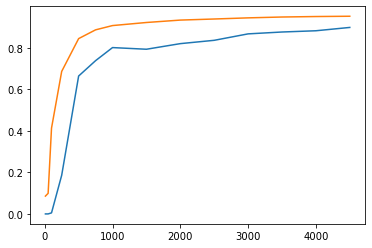

In [5]:
import matplotlib.pyplot as plt
plt.plot(test_num, min_acc, label = "min_acc")
plt.plot(test_num, mean_acc, label = "mean_acc")

In [3]:
from tqdm.notebook import tqdm
import numpy as np
#testing with 3 epochs
test_num = [1000, 750, 500, 250, 100]
min_acc_t = {}
mean_acc_t = {}
for cat in cif_cats:
    for max_num in tqdm(test_num):
        reduced_subset = reduce_to(cifar10_paths,per_cat={cat:max_num})
        tta_acc_example3 = [train_cifar10(reduced_subset, verbose=False, epochs_per_pass=3) for _ in range(1)]
        min_acc_t.setdefault(cat,[]).append(np.min(list(tta_acc_example3[0].values())))
        mean_acc_t.setdefault(cat,[]).append(np.mean(list(tta_acc_example3[0].values())))
        print("%s w. %i samples:"%(cat, max_num), tta_acc_example3[0])

airplane w. 1000 samples: {'truck': 0.971, 'bird': 0.947, 'cat': 0.898, 'automobile': 0.98, 'airplane': 0.888, 'horse': 0.969, 'dog': 0.909, 'frog': 0.973, 'ship': 0.976, 'deer': 0.965}
airplane w. 750 samples: {'truck': 0.962, 'bird': 0.956, 'cat': 0.871, 'automobile': 0.982, 'airplane': 0.831, 'horse': 0.965, 'dog': 0.924, 'frog': 0.982, 'ship': 0.982, 'deer': 0.966}
airplane w. 500 samples: {'truck': 0.972, 'bird': 0.952, 'cat': 0.894, 'automobile': 0.978, 'airplane': 0.789, 'horse': 0.967, 'dog': 0.908, 'frog': 0.972, 'ship': 0.987, 'deer': 0.971}
airplane w. 250 samples: {'truck': 0.973, 'bird': 0.948, 'cat': 0.893, 'automobile': 0.978, 'airplane': 0.669, 'horse': 0.971, 'dog': 0.908, 'frog': 0.975, 'ship': 0.985, 'deer': 0.967}
airplane w. 100 samples: {'truck': 0.967, 'bird': 0.939, 'cat': 0.901, 'automobile': 0.977, 'airplane': 0.438, 'horse': 0.972, 'dog': 0.899, 'frog': 0.983, 'ship': 0.986, 'deer': 0.968}



automobile w. 1000 samples: {'truck': 0.978, 'bird': 0.937, 'cat': 0.906, 'automobile': 0.914, 'airplane': 0.971, 'horse': 0.97, 'dog': 0.9, 'frog': 0.974, 'ship': 0.977, 'deer': 0.966}
automobile w. 750 samples: {'truck': 0.982, 'bird': 0.95, 'cat': 0.893, 'automobile': 0.929, 'airplane': 0.976, 'horse': 0.968, 'dog': 0.901, 'frog': 0.971, 'ship': 0.971, 'deer': 0.972}
automobile w. 500 samples: {'truck': 0.984, 'bird': 0.952, 'cat': 0.889, 'automobile': 0.868, 'airplane': 0.971, 'horse': 0.962, 'dog': 0.901, 'frog': 0.979, 'ship': 0.981, 'deer': 0.968}
automobile w. 250 samples: {'truck': 0.984, 'bird': 0.944, 'cat': 0.884, 'automobile': 0.82, 'airplane': 0.961, 'horse': 0.961, 'dog': 0.919, 'frog': 0.975, 'ship': 0.983, 'deer': 0.964}
automobile w. 100 samples: {'truck': 0.986, 'bird': 0.939, 'cat': 0.889, 'automobile': 0.686, 'airplane': 0.964, 'horse': 0.962, 'dog': 0.898, 'frog': 0.986, 'ship': 0.974, 'deer': 0.969}



bird w. 1000 samples: {'truck': 0.971, 'bird': 0.826, 'cat': 0.878, 'automobile': 0.981, 'airplane': 0.964, 'horse': 0.971, 'dog': 0.911, 'frog': 0.981, 'ship': 0.974, 'deer': 0.972}
bird w. 750 samples: {'truck': 0.961, 'bird': 0.792, 'cat': 0.886, 'automobile': 0.983, 'airplane': 0.97, 'horse': 0.972, 'dog': 0.915, 'frog': 0.98, 'ship': 0.971, 'deer': 0.976}
bird w. 500 samples: {'truck': 0.959, 'bird': 0.761, 'cat': 0.891, 'automobile': 0.983, 'airplane': 0.967, 'horse': 0.961, 'dog': 0.902, 'frog': 0.976, 'ship': 0.979, 'deer': 0.97}
bird w. 250 samples: {'truck': 0.964, 'bird': 0.627, 'cat': 0.894, 'automobile': 0.98, 'airplane': 0.969, 'horse': 0.963, 'dog': 0.895, 'frog': 0.982, 'ship': 0.976, 'deer': 0.975}
bird w. 100 samples: {'truck': 0.968, 'bird': 0.447, 'cat': 0.894, 'automobile': 0.978, 'airplane': 0.971, 'horse': 0.971, 'dog': 0.914, 'frog': 0.981, 'ship': 0.973, 'deer': 0.971}



cat w. 1000 samples: {'truck': 0.966, 'bird': 0.943, 'cat': 0.604, 'automobile': 0.971, 'airplane': 0.977, 'horse': 0.975, 'dog': 0.944, 'frog': 0.98, 'ship': 0.976, 'deer': 0.966}
cat w. 750 samples: {'truck': 0.962, 'bird': 0.955, 'cat': 0.611, 'automobile': 0.979, 'airplane': 0.971, 'horse': 0.967, 'dog': 0.942, 'frog': 0.983, 'ship': 0.971, 'deer': 0.971}
cat w. 500 samples: {'truck': 0.957, 'bird': 0.948, 'cat': 0.482, 'automobile': 0.979, 'airplane': 0.961, 'horse': 0.972, 'dog': 0.941, 'frog': 0.976, 'ship': 0.972, 'deer': 0.959}
cat w. 250 samples: {'truck': 0.965, 'bird': 0.959, 'cat': 0.333, 'automobile': 0.979, 'airplane': 0.962, 'horse': 0.967, 'dog': 0.952, 'frog': 0.982, 'ship': 0.98, 'deer': 0.973}
cat w. 100 samples: {'truck': 0.961, 'bird': 0.941, 'cat': 0.049, 'automobile': 0.974, 'airplane': 0.973, 'horse': 0.975, 'dog': 0.955, 'frog': 0.981, 'ship': 0.979, 'deer': 0.976}



deer w. 1000 samples: {'truck': 0.957, 'bird': 0.954, 'cat': 0.882, 'automobile': 0.984, 'airplane': 0.967, 'horse': 0.971, 'dog': 0.899, 'frog': 0.979, 'ship': 0.979, 'deer': 0.9}
deer w. 750 samples: {'truck': 0.966, 'bird': 0.956, 'cat': 0.888, 'automobile': 0.978, 'airplane': 0.972, 'horse': 0.973, 'dog': 0.906, 'frog': 0.98, 'ship': 0.975, 'deer': 0.843}
deer w. 500 samples: {'truck': 0.965, 'bird': 0.944, 'cat': 0.888, 'automobile': 0.965, 'airplane': 0.978, 'horse': 0.975, 'dog': 0.922, 'frog': 0.976, 'ship': 0.972, 'deer': 0.763}
deer w. 250 samples: {'truck': 0.969, 'bird': 0.948, 'cat': 0.883, 'automobile': 0.979, 'airplane': 0.968, 'horse': 0.978, 'dog': 0.925, 'frog': 0.982, 'ship': 0.983, 'deer': 0.631}
deer w. 100 samples: {'truck': 0.971, 'bird': 0.944, 'cat': 0.902, 'automobile': 0.975, 'airplane': 0.975, 'horse': 0.979, 'dog': 0.915, 'frog': 0.984, 'ship': 0.977, 'deer': 0.447}



dog w. 1000 samples: {'truck': 0.96, 'bird': 0.932, 'cat': 0.933, 'automobile': 0.98, 'airplane': 0.971, 'horse': 0.967, 'dog': 0.766, 'frog': 0.977, 'ship': 0.972, 'deer': 0.975}
dog w. 750 samples: {'truck': 0.973, 'bird': 0.954, 'cat': 0.934, 'automobile': 0.976, 'airplane': 0.965, 'horse': 0.963, 'dog': 0.641, 'frog': 0.979, 'ship': 0.978, 'deer': 0.964}
dog w. 500 samples: {'truck': 0.963, 'bird': 0.945, 'cat': 0.938, 'automobile': 0.972, 'airplane': 0.958, 'horse': 0.976, 'dog': 0.586, 'frog': 0.966, 'ship': 0.983, 'deer': 0.972}
dog w. 250 samples: {'truck': 0.963, 'bird': 0.945, 'cat': 0.943, 'automobile': 0.981, 'airplane': 0.971, 'horse': 0.973, 'dog': 0.442, 'frog': 0.983, 'ship': 0.978, 'deer': 0.969}
dog w. 100 samples: {'truck': 0.968, 'bird': 0.952, 'cat': 0.933, 'automobile': 0.981, 'airplane': 0.959, 'horse': 0.971, 'dog': 0.312, 'frog': 0.977, 'ship': 0.977, 'deer': 0.974}



frog w. 1000 samples: {'truck': 0.967, 'bird': 0.945, 'cat': 0.901, 'automobile': 0.981, 'airplane': 0.968, 'horse': 0.972, 'dog': 0.913, 'frog': 0.918, 'ship': 0.977, 'deer': 0.965}
frog w. 750 samples: {'truck': 0.971, 'bird': 0.945, 'cat': 0.901, 'automobile': 0.966, 'airplane': 0.967, 'horse': 0.971, 'dog': 0.904, 'frog': 0.906, 'ship': 0.976, 'deer': 0.972}
frog w. 500 samples: {'truck': 0.969, 'bird': 0.945, 'cat': 0.903, 'automobile': 0.974, 'airplane': 0.977, 'horse': 0.968, 'dog': 0.913, 'frog': 0.862, 'ship': 0.974, 'deer': 0.974}
frog w. 250 samples: {'truck': 0.96, 'bird': 0.94, 'cat': 0.905, 'automobile': 0.972, 'airplane': 0.969, 'horse': 0.972, 'dog': 0.892, 'frog': 0.814, 'ship': 0.981, 'deer': 0.97}
frog w. 100 samples: {'truck': 0.975, 'bird': 0.952, 'cat': 0.891, 'automobile': 0.977, 'airplane': 0.972, 'horse': 0.965, 'dog': 0.903, 'frog': 0.592, 'ship': 0.979, 'deer': 0.966}



horse w. 1000 samples: {'truck': 0.965, 'bird': 0.941, 'cat': 0.89, 'automobile': 0.975, 'airplane': 0.97, 'horse': 0.904, 'dog': 0.914, 'frog': 0.985, 'ship': 0.975, 'deer': 0.965}
horse w. 750 samples: {'truck': 0.973, 'bird': 0.942, 'cat': 0.879, 'automobile': 0.978, 'airplane': 0.973, 'horse': 0.86, 'dog': 0.909, 'frog': 0.976, 'ship': 0.977, 'deer': 0.97}
horse w. 500 samples: {'truck': 0.969, 'bird': 0.958, 'cat': 0.897, 'automobile': 0.973, 'airplane': 0.973, 'horse': 0.852, 'dog': 0.9, 'frog': 0.976, 'ship': 0.978, 'deer': 0.964}
horse w. 250 samples: {'truck': 0.967, 'bird': 0.954, 'cat': 0.891, 'automobile': 0.981, 'airplane': 0.968, 'horse': 0.664, 'dog': 0.919, 'frog': 0.979, 'ship': 0.975, 'deer': 0.967}
horse w. 100 samples: {'truck': 0.967, 'bird': 0.946, 'cat': 0.885, 'automobile': 0.97, 'airplane': 0.97, 'horse': 0.459, 'dog': 0.916, 'frog': 0.976, 'ship': 0.972, 'deer': 0.976}



ship w. 1000 samples: {'truck': 0.968, 'bird': 0.96, 'cat': 0.884, 'automobile': 0.972, 'airplane': 0.979, 'horse': 0.964, 'dog': 0.908, 'frog': 0.977, 'ship': 0.917, 'deer': 0.977}
ship w. 750 samples: {'truck': 0.969, 'bird': 0.948, 'cat': 0.889, 'automobile': 0.981, 'airplane': 0.981, 'horse': 0.966, 'dog': 0.909, 'frog': 0.975, 'ship': 0.882, 'deer': 0.967}
ship w. 500 samples: {'truck': 0.971, 'bird': 0.939, 'cat': 0.907, 'automobile': 0.974, 'airplane': 0.975, 'horse': 0.969, 'dog': 0.902, 'frog': 0.981, 'ship': 0.883, 'deer': 0.976}
ship w. 250 samples: {'truck': 0.969, 'bird': 0.95, 'cat': 0.886, 'automobile': 0.979, 'airplane': 0.981, 'horse': 0.969, 'dog': 0.915, 'frog': 0.976, 'ship': 0.809, 'deer': 0.967}
ship w. 100 samples: {'truck': 0.967, 'bird': 0.948, 'cat': 0.89, 'automobile': 0.976, 'airplane': 0.975, 'horse': 0.976, 'dog': 0.895, 'frog': 0.983, 'ship': 0.644, 'deer': 0.972}



truck w. 1000 samples: {'truck': 0.926, 'bird': 0.945, 'cat': 0.892, 'automobile': 0.981, 'airplane': 0.97, 'horse': 0.975, 'dog': 0.904, 'frog': 0.985, 'ship': 0.983, 'deer': 0.96}
truck w. 750 samples: {'truck': 0.916, 'bird': 0.946, 'cat': 0.888, 'automobile': 0.987, 'airplane': 0.973, 'horse': 0.97, 'dog': 0.903, 'frog': 0.978, 'ship': 0.974, 'deer': 0.969}
truck w. 500 samples: {'truck': 0.811, 'bird': 0.948, 'cat': 0.883, 'automobile': 0.986, 'airplane': 0.967, 'horse': 0.963, 'dog': 0.912, 'frog': 0.981, 'ship': 0.982, 'deer': 0.97}
truck w. 250 samples: {'truck': 0.775, 'bird': 0.952, 'cat': 0.891, 'automobile': 0.99, 'airplane': 0.972, 'horse': 0.968, 'dog': 0.913, 'frog': 0.976, 'ship': 0.98, 'deer': 0.97}
truck w. 100 samples: {'truck': 0.617, 'bird': 0.957, 'cat': 0.893, 'automobile': 0.995, 'airplane': 0.972, 'horse': 0.963, 'dog': 0.885, 'frog': 0.973, 'ship': 0.973, 'deer': 0.97}



In [8]:
import json
test_num_old = [4500, 4000, 3500, 3000, 2500, 2000, 1500, 1000, 750, 500, 250, 100, 50, 10]
json.dump({'t0':test_num_old, 't1':test_num, 
#          'min_acc':min_acc, 'mean_acc':mean_acc,
          'min_acc_t':min_acc_t, 'mean_acc_t':mean_acc_t}, open('res.json','wt'))

In [31]:
r0 = json.load(open('res.json','r'))

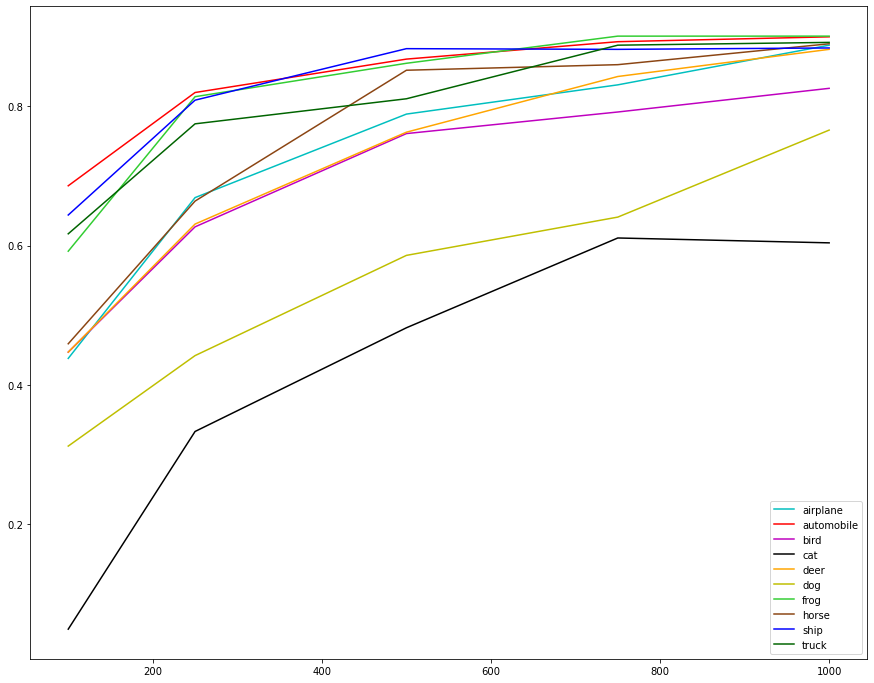

In [41]:
import matplotlib.pyplot as plt
cif_col = {'airplane':'c', 'automobile':'r', 'bird':'m', 'cat':'k', 'deer':'orange', 'dog':'y', 'frog':'limegreen', 'horse':'saddlebrown', 'ship':'b', 'truck':'darkgreen'}
plt.subplots(figsize=(15, 12))
for k, v in r0['min_acc_t'].items():
    plt.plot(r0['t1'], v, label = k, color=cif_col[k])
plt.legend()
plt.show()

In [5]:
from tqdm.notebook import tqdm
import numpy as np
#testing with 3 epochs
min_acc_t = {}
mean_acc_t = {}
test_red = [1,2,4,8,16]
max_nums = []
for cat in ['automobile','cat','dog','ship']:
    for redundancy in tqdm(test_red):
        max_num = 1000/redundancy
        max_nums.append(max_num)
        reduce_to(cifar10_paths, max_num=1000, per_cat={cat:max_num}, multiple_cat={cat:redundancy})
        reduced_subset = reduce_to(cifar10_paths,per_cat={cat:max_num})
        tta_acc_example3 = [train_cifar10(reduced_subset, verbose=False, epochs_per_pass=3) for _ in range(1)]
        min_acc_t.setdefault(cat,[]).append(np.min(list(tta_acc_example3[0].values())))
        mean_acc_t.setdefault(cat,[]).append(np.mean(list(tta_acc_example3[0].values())))
        print("%s w. %i samples:"%(cat, max_num), tta_acc_example3[0])

automobile w. 1000 samples: {'truck': 0.982, 'bird': 0.939, 'cat': 0.886, 'automobile': 0.923, 'airplane': 0.966, 'horse': 0.97, 'dog': 0.911, 'frog': 0.976, 'ship': 0.98, 'deer': 0.965}
automobile w. 500 samples: {'truck': 0.983, 'bird': 0.958, 'cat': 0.895, 'automobile': 0.875, 'airplane': 0.97, 'horse': 0.964, 'dog': 0.902, 'frog': 0.973, 'ship': 0.976, 'deer': 0.972}
automobile w. 250 samples: {'truck': 0.986, 'bird': 0.954, 'cat': 0.893, 'automobile': 0.811, 'airplane': 0.96, 'horse': 0.962, 'dog': 0.904, 'frog': 0.983, 'ship': 0.979, 'deer': 0.966}
automobile w. 125 samples: {'truck': 0.987, 'bird': 0.947, 'cat': 0.893, 'automobile': 0.664, 'airplane': 0.97, 'horse': 0.969, 'dog': 0.901, 'frog': 0.972, 'ship': 0.966, 'deer': 0.973}
automobile w. 62 samples: {'truck': 0.983, 'bird': 0.944, 'cat': 0.891, 'automobile': 0.518, 'airplane': 0.984, 'horse': 0.959, 'dog': 0.909, 'frog': 0.973, 'ship': 0.97, 'deer': 0.959}



cat w. 1000 samples: {'truck': 0.974, 'bird': 0.947, 'cat': 0.626, 'automobile': 0.976, 'airplane': 0.977, 'horse': 0.97, 'dog': 0.945, 'frog': 0.981, 'ship': 0.974, 'deer': 0.965}
cat w. 500 samples: {'truck': 0.971, 'bird': 0.938, 'cat': 0.47, 'automobile': 0.978, 'airplane': 0.971, 'horse': 0.97, 'dog': 0.964, 'frog': 0.986, 'ship': 0.975, 'deer': 0.968}
cat w. 250 samples: {'truck': 0.967, 'bird': 0.945, 'cat': 0.315, 'automobile': 0.974, 'airplane': 0.965, 'horse': 0.967, 'dog': 0.952, 'frog': 0.983, 'ship': 0.974, 'deer': 0.974}
cat w. 125 samples: {'truck': 0.965, 'bird': 0.951, 'cat': 0.194, 'automobile': 0.972, 'airplane': 0.978, 'horse': 0.964, 'dog': 0.952, 'frog': 0.979, 'ship': 0.969, 'deer': 0.969}
cat w. 62 samples: {'truck': 0.959, 'bird': 0.939, 'cat': 0.007, 'automobile': 0.976, 'airplane': 0.967, 'horse': 0.967, 'dog': 0.961, 'frog': 0.978, 'ship': 0.974, 'deer': 0.974}



dog w. 1000 samples: {'truck': 0.968, 'bird': 0.943, 'cat': 0.93, 'automobile': 0.976, 'airplane': 0.969, 'horse': 0.972, 'dog': 0.749, 'frog': 0.98, 'ship': 0.979, 'deer': 0.965}
dog w. 500 samples: {'truck': 0.967, 'bird': 0.947, 'cat': 0.925, 'automobile': 0.98, 'airplane': 0.968, 'horse': 0.972, 'dog': 0.594, 'frog': 0.978, 'ship': 0.976, 'deer': 0.971}
dog w. 250 samples: {'truck': 0.972, 'bird': 0.948, 'cat': 0.93, 'automobile': 0.97, 'airplane': 0.971, 'horse': 0.978, 'dog': 0.457, 'frog': 0.978, 'ship': 0.979, 'deer': 0.979}
dog w. 125 samples: {'truck': 0.972, 'bird': 0.963, 'cat': 0.942, 'automobile': 0.979, 'airplane': 0.956, 'horse': 0.975, 'dog': 0.32, 'frog': 0.98, 'ship': 0.981, 'deer': 0.961}
dog w. 62 samples: {'truck': 0.963, 'bird': 0.954, 'cat': 0.933, 'automobile': 0.977, 'airplane': 0.968, 'horse': 0.966, 'dog': 0.198, 'frog': 0.979, 'ship': 0.988, 'deer': 0.966}



ship w. 1000 samples: {'truck': 0.966, 'bird': 0.952, 'cat': 0.881, 'automobile': 0.98, 'airplane': 0.976, 'horse': 0.97, 'dog': 0.901, 'frog': 0.975, 'ship': 0.911, 'deer': 0.956}
ship w. 500 samples: {'truck': 0.963, 'bird': 0.952, 'cat': 0.896, 'automobile': 0.976, 'airplane': 0.981, 'horse': 0.972, 'dog': 0.902, 'frog': 0.978, 'ship': 0.863, 'deer': 0.964}
ship w. 250 samples: {'truck': 0.97, 'bird': 0.938, 'cat': 0.895, 'automobile': 0.973, 'airplane': 0.982, 'horse': 0.97, 'dog': 0.92, 'frog': 0.979, 'ship': 0.826, 'deer': 0.968}
ship w. 125 samples: {'truck': 0.975, 'bird': 0.939, 'cat': 0.886, 'automobile': 0.978, 'airplane': 0.973, 'horse': 0.976, 'dog': 0.907, 'frog': 0.98, 'ship': 0.673, 'deer': 0.966}
ship w. 62 samples: {'truck': 0.976, 'bird': 0.935, 'cat': 0.901, 'automobile': 0.975, 'airplane': 0.976, 'horse': 0.96, 'dog': 0.905, 'frog': 0.981, 'ship': 0.597, 'deer': 0.968}



In [23]:
r1 = json.load(open('res1.json','r'))

In [14]:
r0['min_acc_t']

{'airplane': [0.888, 0.831, 0.789, 0.669, 0.438],
 'automobile': [0.9, 0.893, 0.868, 0.82, 0.686],
 'bird': [0.826, 0.792, 0.761, 0.627, 0.447],
 'cat': [0.604, 0.611, 0.482, 0.333, 0.049],
 'deer': [0.882, 0.843, 0.763, 0.631, 0.447],
 'dog': [0.766, 0.641, 0.586, 0.442, 0.312],
 'frog': [0.901, 0.901, 0.862, 0.814, 0.592],
 'horse': [0.89, 0.86, 0.852, 0.664, 0.459],
 'ship': [0.884, 0.882, 0.883, 0.809, 0.644],
 'truck': [0.892, 0.888, 0.811, 0.775, 0.617]}

In [22]:
from tqdm.notebook import tqdm
import numpy as np
#testing with 3 epochs
min_acc_t = {}
mean_acc_t = {}
test_red = [1,2,3,4,8,12,16]
max_nums = []

for redundancy in tqdm(test_red):
    max_num = 1000/redundancy
    max_nums.append(max_num)
    for cat in ['automobile','cat','dog','truck']:
        #strategies: under; all classes have an equal number of entries from the lowest number
        #strategies: imbalance; = all classes have a full number of entries, one is reduced
        #strategies: over; all classes have a full number of entries, one is oversampled
        for strat in ['_under','_imb','_over']:
            max_num_all = max_num if strat == '_under' else 1000
            reduced_subset = reduce_to(cifar10_paths, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
            tta_acc_example3 = [train_cifar10(reduced_subset, verbose=False, epochs_per_pass=10) for _ in range(1)]
            store_name = cat+strat
            min_acc_t.setdefault(store_name,[]).append(np.min(list(tta_acc_example3[0].values())))
            mean_acc_t.setdefault(store_name,[]).append(np.mean(list(tta_acc_example3[0].values())))
            print("%s w. %i samples:"%(store_name, max_num), tta_acc_example3[0])

automobile_under w. 1000 samples: {'truck': 0.954, 'bird': 0.91, 'cat': 0.872, 'automobile': 0.964, 'airplane': 0.937, 'horse': 0.95, 'dog': 0.868, 'frog': 0.966, 'ship': 0.968, 'deer': 0.939}
automobile_imb w. 1000 samples: {'truck': 0.965, 'bird': 0.914, 'cat': 0.86, 'automobile': 0.948, 'airplane': 0.935, 'horse': 0.938, 'dog': 0.876, 'frog': 0.972, 'ship': 0.975, 'deer': 0.943}
automobile_over w. 1000 samples: {'truck': 0.967, 'bird': 0.924, 'cat': 0.815, 'automobile': 0.949, 'airplane': 0.955, 'horse': 0.947, 'dog': 0.867, 'frog': 0.968, 'ship': 0.965, 'deer': 0.938}
cat_under w. 1000 samples: {'truck': 0.958, 'bird': 0.918, 'cat': 0.84, 'automobile': 0.966, 'airplane': 0.941, 'horse': 0.952, 'dog': 0.874, 'frog': 0.965, 'ship': 0.964, 'deer': 0.96}
cat_imb w. 1000 samples: {'truck': 0.958, 'bird': 0.926, 'cat': 0.849, 'automobile': 0.956, 'airplane': 0.941, 'horse': 0.961, 'dog': 0.867, 'frog': 0.964, 'ship': 0.965, 'deer': 0.939}
cat_over w. 1000 samples: {'truck': 0.963, 'bird'

dog_over w. 250 samples: {'truck': 0.961, 'bird': 0.92, 'cat': 0.88, 'automobile': 0.957, 'airplane': 0.947, 'horse': 0.953, 'dog': 0.713, 'frog': 0.965, 'ship': 0.96, 'deer': 0.936}
truck_under w. 250 samples: {'truck': 0.925, 'bird': 0.85, 'cat': 0.77, 'automobile': 0.918, 'airplane': 0.925, 'horse': 0.899, 'dog': 0.77, 'frog': 0.907, 'ship': 0.879, 'deer': 0.789}
truck_imb w. 250 samples: {'truck': 0.858, 'bird': 0.915, 'cat': 0.843, 'automobile': 0.976, 'airplane': 0.96, 'horse': 0.957, 'dog': 0.886, 'frog': 0.968, 'ship': 0.954, 'deer': 0.927}
truck_over w. 250 samples: {'truck': 0.894, 'bird': 0.919, 'cat': 0.844, 'automobile': 0.97, 'airplane': 0.949, 'horse': 0.941, 'dog': 0.888, 'frog': 0.966, 'ship': 0.957, 'deer': 0.95}
automobile_under w. 125 samples: {'truck': 0.84, 'bird': 0.555, 'cat': 0.617, 'automobile': 0.939, 'airplane': 0.892, 'horse': 0.918, 'dog': 0.719, 'frog': 0.74, 'ship': 0.858, 'deer': 0.613}
automobile_imb w. 125 samples: {'truck': 0.971, 'bird': 0.91, 'cat'

In [58]:
from cifar10_trainer import cif_cats
test_red = [1,2,3,4,8,12,16]
set0 = 'r4'
#res_cat = {}
for redundancy in tqdm(test_red):
    max_num = int(1000/redundancy)
    max_nums.append(max_num)
    for cat in cif_cats:
        trgname = '%s_%s_%s_foc'%(max_num,set0,cat)
        if trgname in res_cat:
            continue
        max_num = int(1000/redundancy)
        strat='_imb'
        max_num_all = max_num if strat == '_under' else 1000
        reduced_subset = reduce_paths(set0, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
        tta_acc_example3_foc = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass, weights_per_class= {cat:redundancy})
        res_cat[trgname] = tta_acc_example3_foc

In [63]:
res_cati = {}
for k, v in res_cat.items():
    num = k.split('_')[0]
    if '.' in num:
        num1 = "%i"%int(float(num))
        k = k.replace(num,num1)
    res_cati[k] = v

In [66]:
len(res_cat.keys())

70

In [67]:
import json
json.dump(res_cati, open('res9_foc.json','wt'))

In [20]:
import json
json.dump({'t6':max_num, 
          'min_acc_t':min_acc_t, 'mean_acc_t':mean_acc_t}, open('res6.json','wt'))

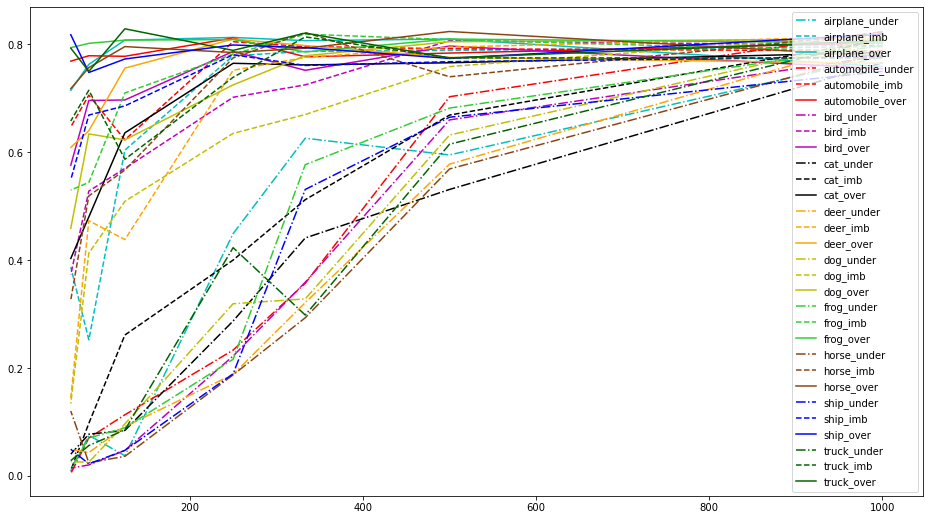

In [21]:
import matplotlib.pyplot as plt
#add_col={'automobile':'b','cat':'y','dog':'g','ship':'r'}
plt.subplots(figsize=(16, 9))
for k, v in min_acc_t.items():
    plt.plot(max_nums, v, label = k, color=cif_col[k.split('_')[0]], linestyle='--' if '_imb' in k else ('-' if '_over' in k else '-.'))

plt.legend()
plt.show()

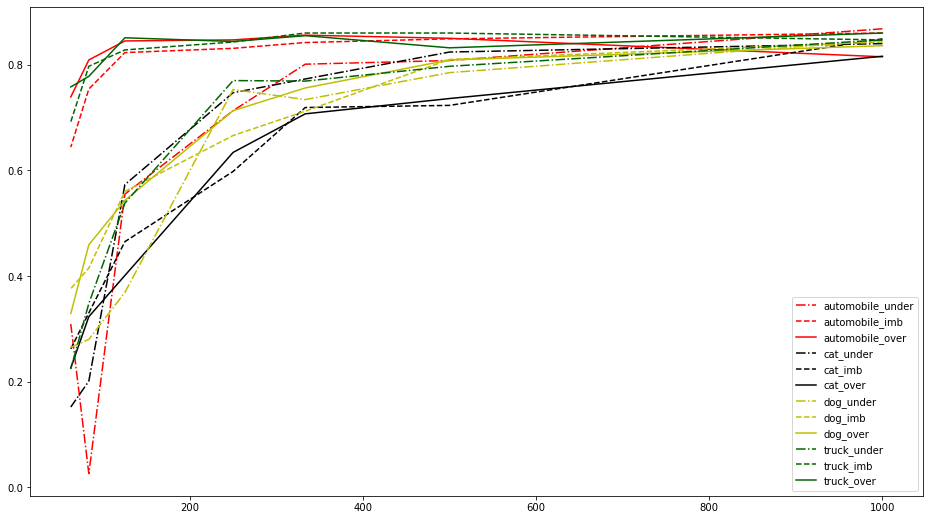

In [23]:
import matplotlib.pyplot as plt
#add_col={'automobile':'b','cat':'y','dog':'g','ship':'r'}
plt.subplots(figsize=(16, 9))
for k, v in min_acc_t.items():
    plt.plot(max_nums, v, label = k, color=cif_col[k.split('_')[0]], linestyle='--' if '_imb' in k else ('-' if '_over' in k else '-.'))

plt.legend()
plt.show()

In [4]:
from tqdm.notebook import tqdm
#from train_cifar10 import train_cifar10
import numpy as np

test_red = [1,2,3,4,8,12,16]
max_nums = []

redundancy=8
res_cat = {}
for epochs_per_pass in tqdm(range(10,18)):
    max_num = 1000/redundancy
    cat='cat'
    strat='_imb'
    max_num_all = max_num if strat == '_under' else 1000
    reduced_subset = reduce_to(cifar10_paths, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
    #tta_acc_example3_imb = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass)
    tta_acc_example3_foc = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass, weights_per_class= {cat:redundancy})
    res_cat['%i_foc'%epochs_per_pass] = tta_acc_example3_foc
    strat == '_over'
    reduced_subset = reduce_to(cifar10_paths, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
    tta_acc_example3_over = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass)
    res_cat['%i_over'%epochs_per_pass] = tta_acc_example3_over
    print("cmp", epochs_per_pass, tta_acc_example3_foc['cat'], tta_acc_example3_over['cat'])

cmp 10 0.569 0.456
cmp 11 0.595 0.473
cmp 12 0.577 0.453
cmp 13 0.538 0.443
cmp 14 0.542 0.419
cmp 15 0.548 0.418
cmp 16 0.533 0.44
cmp 17 0.46 0.451



In [ ]:
from cifar10_trainer import train_cifar10, reduce_paths, cif_sets, cif_cats, cif_col
import numpy as np
from tqdm.notebook import tqdm

test_red = [1,2,3,4,8,12,16]
max_nums = []
epochs_per_pass = 11
redundancy=2
res_cat = {}
cif_sets0 = ['i0', 'i1', 'i2', 'I0', 'I1', 'I2'] # + [s for s in cif_sets if s[0]!='r']
for set0 in tqdm(cif_sets0):
    for cat in ['automobile','cat','dog','truck']:
        max_num = 1000/redundancy
        strat='_imb'
        max_num_all = max_num if strat == '_under' else 1000
        reduced_subset = reduce_paths(set0, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
        #tta_acc_example3_imb = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass)
        tta_acc_example3_foc = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass, weights_per_class= {cat:redundancy})
        res_cat['%s_%s_foc'%(set0,cat)] = tta_acc_example3_foc
        strat == '_over'
        reduced_subset = reduce_paths(set0, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
        tta_acc_example3_over = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass)
        res_cat['%s_%s_over'%(set0,cat)] = tta_acc_example3_over
        reduced_subset = reduce_paths(set0, max_num=max_num)
        name0 = '%s_%s_under'%(set0,cat)
        if name0 in res_cat:
            continue
        tta_acc_example3_under = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass)
        res_cat[name0] = tta_acc_example3_under
        print("cmp", set0, tta_acc_example3_foc[cat], tta_acc_example3_over[cat], tta_acc_example3_under[cat], np.mean(list(tta_acc_example3_under.values())))

cmp i0 0.95 0.908 0.947 0.8109
cmp i0 0.739 0.663 0.725 0.8013999999999999
cmp i0 0.65 0.618 0.662 0.8093999999999999
cmp i0 0.88 0.873 0.923 0.8157
cmp i1 0.923 0.923 0.912 0.8311
cmp i1 0.765 0.692 0.788 0.8281000000000001
cmp i1 0.661 0.634 0.694 0.8285
cmp i1 0.903 0.885 0.909 0.8217000000000001
cmp i2 0.934 0.924 0.923 0.8314
cmp i2 0.757 0.735 0.78 0.8422000000000001
cmp i2 0.702 0.656 0.682 0.8311


In [69]:
cmp0 = json.load(open('res250.json','r'))

In [70]:
print(max_num)

500.0


In [71]:
res_cat.update(cmp0)

In [72]:
json.dump(res_cat, open('res250.json','wt'))

In [47]:
[print(p,v) for p,v in res_cat.items() if 'cat' in p and 'under' in p]

m0_cat_under {'airplane': 0.796, 'automobile': 0.903, 'bird': 0.802, 'cat': 0.708, 'deer': 0.801, 'dog': 0.543, 'frog': 0.894, 'horse': 0.639, 'ship': 0.891, 'truck': 0.898}
m1_cat_under {'airplane': 0.825, 'automobile': 0.922, 'bird': 0.841, 'cat': 0.657, 'deer': 0.865, 'dog': 0.796, 'frog': 0.923, 'horse': 0.74, 'ship': 0.831, 'truck': 0.907}
m2_cat_under {'airplane': 0.794, 'automobile': 0.87, 'bird': 0.735, 'cat': 0.681, 'deer': 0.841, 'dog': 0.699, 'frog': 0.838, 'horse': 0.556, 'ship': 0.684, 'truck': 0.911}
m3_cat_under {'airplane': 0.876, 'automobile': 0.94, 'bird': 0.818, 'cat': 0.74, 'deer': 0.789, 'dog': 0.782, 'frog': 0.886, 'horse': 0.925, 'ship': 0.891, 'truck': 0.949}
r0_cat_under {'airplane': 0.915, 'automobile': 0.94, 'bird': 0.856, 'cat': 0.744, 'deer': 0.849, 'dog': 0.741, 'frog': 0.895, 'horse': 0.912, 'ship': 0.922, 'truck': 0.935}
r1_cat_under {'airplane': 0.931, 'automobile': 0.949, 'bird': 0.867, 'cat': 0.759, 'deer': 0.835, 'dog': 0.767, 'frog': 0.889, 'horse':

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [48]:
[print(p,v) for p,v in cmp0.items() if p[0]=='r' and 'cat' in p and 'under' in p]

r0_cat_under {'airplane': 0.915, 'automobile': 0.94, 'bird': 0.856, 'cat': 0.744, 'deer': 0.849, 'dog': 0.741, 'frog': 0.895, 'horse': 0.912, 'ship': 0.922, 'truck': 0.935}
r1_cat_under {'airplane': 0.931, 'automobile': 0.949, 'bird': 0.867, 'cat': 0.759, 'deer': 0.835, 'dog': 0.767, 'frog': 0.889, 'horse': 0.918, 'ship': 0.892, 'truck': 0.905}
r2_cat_under {'airplane': 0.84, 'automobile': 0.914, 'bird': 0.849, 'cat': 0.796, 'deer': 0.768, 'dog': 0.8, 'frog': 0.925, 'horse': 0.868, 'ship': 0.938, 'truck': 0.902}


[None, None, None]

In [38]:
sorted({k:v['cat'] for k, v in res_cat.items()}.items(), key=lambda x: x[1])

In [12]:
import json
print(max_num)
json.dump(res_cat, open('res333.json','wt'))

333.3333333333333


In [ ]:
#OLD order (no weighting):
cmp r0 0.662 0.469 0.499 0.7865
cmp r1 0.581 0.486 0.647 0.8261000000000001
cmp r2 0.618 0.479 0.667 0.8020000000000002
cmp B0 0.55 0.337 0.6 0.6971
cmp B1 0.615 0.488 0.645 0.7916000000000001
cmp B2 0.561 0.496 0.597 0.7979
cmp b0 0.549 0.397 0.516 0.7263000000000001
cmp b1 0.516 0.459 0.709 0.7904
cmp b2 0.561 0.437 0.505 0.7932999999999999
cmp w0 0.563 0.449 0.625 0.7379999999999999
cmp w1 0.54 0.467 0.574 0.7586
cmp w2 0.591 0.417 0.651 0.75
cmp W0 0.559 0.476 0.569 0.7351
cmp W1 0.608 0.486 0.68 0.7444
cmp W2 0.64 0.467 0.695 0.7615000000000001

In [11]:
res_cat

{'11_foc': {'airplane': 0.92,
  'automobile': 0.931,
  'bird': 0.871,
  'cat': 0.64,
  'deer': 0.905,
  'dog': 0.797,
  'frog': 0.951,
  'horse': 0.87,
  'ship': 0.942,
  'truck': 0.943},
 '11_over': {'airplane': 0.894,
  'automobile': 0.949,
  'bird': 0.897,
  'cat': 0.467,
  'deer': 0.938,
  'dog': 0.854,
  'frog': 0.948,
  'horse': 0.909,
  'ship': 0.954,
  'truck': 0.942},
 '11_under': {'airplane': 0.77,
  'automobile': 0.922,
  'bird': 0.761,
  'cat': 0.695,
  'deer': 0.657,
  'dog': 0.662,
  'frog': 0.912,
  'horse': 0.681,
  'ship': 0.854,
  'truck': 0.701}}

In [ ]:
b0, B0, w0, W0, 
r0, b2, W0, 

In [ ]:
{'truck': 0.97, 'bird': 0.917, 'cat': 0.476, 'automobile': 0.941, 'airplane': 0.955, 'horse': 0.953, 'dog': 0.925, 'frog': 0.971, 'ship': 0.962, 'deer': 0.957} 
{'truck': 0.953, 'bird': 0.901, 'cat': 0.584, 'automobile': 0.948, 'airplane': 0.943, 'horse': 0.934, 'dog': 0.905, 'frog': 0.957, 'ship': 0.957, 'deer': 0.945} 
{'truck': 0.971, 'bird': 0.921, 'cat': 0.49, 'automobile': 0.946, 'airplane': 0.944, 'horse': 0.947, 'dog': 0.93, 'frog': 0.96, 'ship': 0.97, 'deer': 0.951}

In [ ]:
strat == '_over'
max_num_all = max_num if strat == '_under' else 1000
reduced_subset = reduce_to(cifar10_paths, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
tta_acc_example3_over = train_cifar10(reduced_subset, verbose=True, epochs_per_pass=3)

In [ ]:
import torch
from torchvision.models import resnet34
from fastai2.vision.all import cnn_learner, accuracy, CSVLogger
from fastai2.vision.all import ProgressCallback
from fastai2.data.transforms import RegexLabeller
from fastai2.vision.all import aug_transforms, Normalize, DataBlock, ImageBlock, CategoryBlock, Resize, IndexSplitter
from torchvision.transforms import RandomCrop, RandomHorizontalFlip
#necessary for recorder metrics printout
import fastai_metrics 
from fastai_metrics import silent_progress, plot_confusion_matrix

import contextlib
import matplotlib.pyplot as plt
import os, glob
from collections import Counter
import numpy as np

idx_train=10000 # the first x cifar10_paths should be validation paths; remainder training
model=resnet34 
epochs_per_pass = 10
bs = 512  #resnet34 w. bs 512 fits easily on Titan RTX (22GB of RAM); larger bs do not increase speed
img_dim_load = 128  # this is larger than the input 32x32; givings augmentations a larger chance to pad/augment
img_dim_cif = 96 # this is also larger than the input; giving model larger receptive field)
verbose = True

get_cls = RegexLabeller(pat = r'.*/(.*)/')
#default fastai augmentations (reflective padding, horizontal flipping, up to 10 deg rotation;)
#see https://docs.fast.ai/vision.augment.html#aug_transforms
#parameters based on https://gist.github.com/rlandingin/e09e2e568e964466fc3b5634bf18d87a
tfms = [*aug_transforms(size=img_dim_cif, min_scale=0.8, max_zoom=1.1, max_lighting=0.4),
        Normalize.from_stats(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])]

#creating a DataBlock 'from_folder' would work but we want to exclude or dublicate images later
# (i.e. redundancy) -> this can be easily achived using file paths
dblock = DataBlock(
  blocks=(ImageBlock, CategoryBlock),      # one image input and one categorical target
  splitter=IndexSplitter(range(0,idx_train)),
  batch_tfms=tfms,
  item_tfms=[Resize(img_dim_cif)],
  get_items = lambda x:(reduced_subset),
  get_y     =  get_cls)
ods_train = dblock.dataloaders('./',bs=bs)

bad_valid = [t for t in ods_train.valid_ds.items if not '/test/' in t] #just a precaution to make sure validation frames are not in the training set
assert len(bad_valid) == 0 or len(ods_train.valid_ds.items) != idx_train, "There are invalid validation frames in the dataloader"
if verbose:
    print("Using: ", len(ods_train.train_ds.items), len(ods_train.valid_ds.items), len(bad_valid))
    ods_train.show_batch(max_n=9 , figsize=(5,5))
    plt.show()
    
#learn = cnn_learner(ods_train, model, metrics=accuracy, pretrained=True)#, loss_func=torch.nn.CrossEntropyLoss(weight=weights_per_class))


In [162]:
vocab_inv = {v:k for k,v in ods_train.vocab.o2i.items()}
all_weights = [weights_per_class.get(vocab_inv[i],1.0) for i in range(len(vocab_inv))]
weight_cel= pyttensor([1.] * np.array(all_weights)).cuda()
print(all_weights)

[1.0, 1.0, 1.0, 8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [167]:
from torch import Tensor as pyttensor
from torch.nn import CrossEntropyLoss
weight_cel= pyttensor([1.] * np.array(all_weights)).cuda()
learn = cnn_learner(ods_train, model, metrics=accuracy, pretrained=True, loss_func=FocalLoss(weight=weight_cel))

In [164]:
from fastai2.imports import use_kwargs_dict
# taken from  https://github.com/fastai/fastai/blob/52d6302eb4487e86382e663ef5c10ee950c07ad1/fastai/losses.py
class FocalLossFlat(CrossEntropyLossFlat):
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss

In [165]:
from fastai2.imports import use_kwargs_dict
from torch.nn import CrossEntropyLoss
# taken from  https://github.com/fastai/fastai/blob/52d6302eb4487e86382e663ef5c10ee950c07ad1/fastai/losses.py
class FocalLoss(CrossEntropyLoss):
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss

In [122]:
import fastai2.data.all as faiv
[f for f in dir(faiv) if 'oss' in f]

['BCELossFlat',
 'BCEWithLogitsLossFlat',
 'BaseLoss',
 'CrossEntropyLossFlat',
 'L1LossFlat',
 'LabelSmoothingCrossEntropy',
 'LabelSmoothingCrossEntropyFlat',
 'MSELossFlat',
 'make_cross_image']

In [155]:
from  fastai2.data.all import CrossEntropyLossFlat, LabelSmoothingCrossEntropyFlat
from torch.nn import MSELoss
learn = cnn_learner(ods_train, model, metrics=accuracy, pretrained=True, loss_func=CrossEntropyLoss())#, loss_func=FocalLoss())#(weight=weight_cel))

epoch,train_loss,valid_loss,accuracy,time
0,3.306968,3.631177,0.424100,00:08
1,2.430425,2.136254,0.711200,00:08
2,1.801607,1.622037,0.780100,00:08
3,1.395684,1.567664,0.804800,00:08
4,1.123500,1.430957,0.817700,00:07
5,0.934818,1.365633,0.828900,00:07
6,0.808340,1.176491,0.838900,00:07
7,0.700870,1.221279,0.837200,00:07
8,0.631183,1.225829,0.839600,00:07
9,0.578361,1.203157,0.838800,00:07


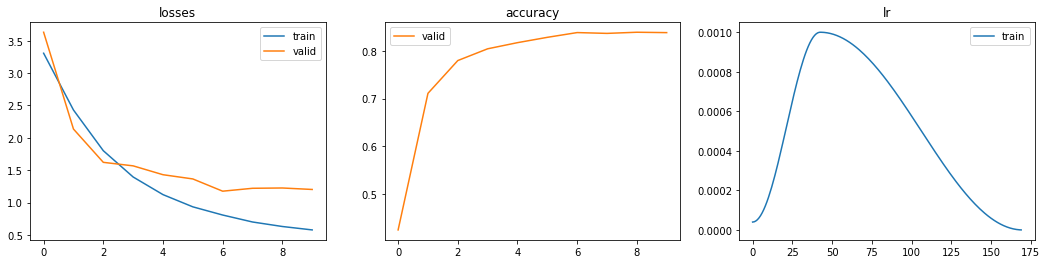

epoch,train_loss,valid_loss,accuracy,time
0,0.456923,4.236444,0.781600,00:07
1,0.428375,2.354634,0.754300,00:08
2,0.432592,15.894578,0.654900,00:07
3,0.410217,2.291719,0.737800,00:08
4,0.353540,1.966101,0.819300,00:08
5,0.304098,1.480596,0.834900,00:07
6,0.251296,1.496264,0.864100,00:08
7,0.200232,1.380747,0.874700,00:08
8,0.159378,1.410854,0.879300,00:08
9,0.129859,1.390721,0.879200,00:08


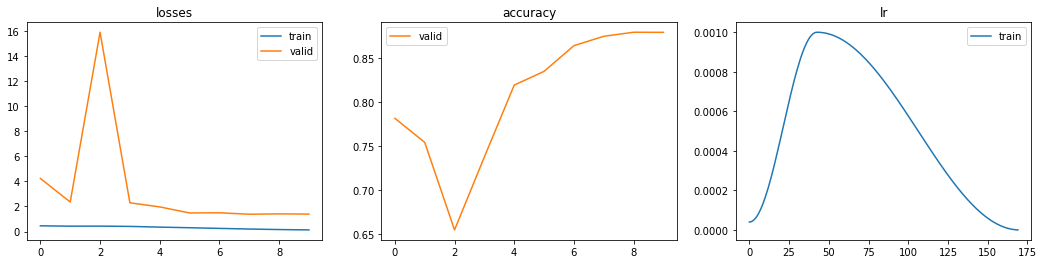

{'truck': 0.958, 'bird': 0.906, 'cat': 0.575, 'automobile': 0.956, 'airplane': 0.922, 'horse': 0.923, 'dog': 0.87, 'frog': 0.965, 'ship': 0.955, 'deer': 0.937}


In [168]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])
for epoch_passes in [epochs_per_pass,epochs_per_pass]:
    learn.fit_one_cycle(epochs_per_pass) # per default all but the last two layers are frozen
    learn.recorder.plot_metrics()
    learn.unfreeze() # unfreezes all layers
learn.remove_cb(ProgressCallback) #necessary due to strange bug (see https://github.com/fastai/fastprogress/issues/72)
res = learn.tta(n=10)
#calculate per-class accuracy
vocab_inv = {v:k for k,v in ods_train.vocab.o2i.items()}
val_trg = [t.item() for t in res[1]]
val_res = [t.argmax().item() for t in res[0]]

corr_pred = {'all':0}
for i in range(idx_train):
    if val_trg[i] == val_res[i]:
        corr_pred[val_trg[i]] = corr_pred.get(val_trg[i],0)+1
        corr_pred['all'] += 1
count_idx = Counter(val_trg)
acc_per_class = {vocab_inv[c]:corr_pred.get(c,0)/count_idx[c] for c in count_idx}
print(acc_per_class)

In [169]:
#acc/class CrossEntropyLoss(weights):
#orig: FlattenedLoss of CrossEntropyLoss() == CrossEntropyLossFlat
#focf: FocalLossFlat
#lsc: LabelSmoothingCrossEntropy
cmp_acc = {'orig': {'truck': 0.965, 'bird': 0.882, 'cat': 0.224, 'automobile': 0.93, 'airplane': 0.902, 'horse': 0.901, 'dog': 0.91, 'frog': 0.96, 'ship': 0.95, 'deer': 0.893},
'3ep_cel_w': {'truck': 0.892, 'bird': 0.842, 'cat': 0.609, 'automobile': 0.971, 'airplane': 0.913, 'horse': 0.902, 'dog': 0.724, 'frog': 0.914, 'ship': 0.924, 'deer': 0.896},
'3ep_cel':{'truck': 0.932, 'bird': 0.908, 'cat': 0.209, 'automobile': 0.963, 'airplane': 0.906, 'horse': 0.906, 'dog': 0.924, 'frog': 0.927, 'ship': 0.941, 'deer': 0.925},
'3ep_celf':{'truck': 0.943, 'bird': 0.903, 'cat': 0.21, 'automobile': 0.93, 'airplane': 0.926, 'horse': 0.905, 'dog': 0.895, 'frog': 0.957, 'ship': 0.948, 'deer': 0.929},
'3ep_celf_w':{'truck': 0.907, 'bird': 0.897, 'cat': 0.608, 'automobile': 0.927, 'airplane': 0.909, 'horse': 0.905, 'dog': 0.816, 'frog': 0.927, 'ship': 0.949, 'deer': 0.898},
'3ep_focf':{'truck': 0.922, 'bird': 0.898, 'cat': 0.155, 'automobile': 0.938, 'airplane': 0.951, 'horse': 0.955, 'dog': 0.846, 'frog': 0.954, 'ship': 0.893, 'deer': 0.885},
'3ep_focf_w':{'truck': 0.916, 'bird': 0.81, 'cat': 0.615, 'automobile': 0.947, 'airplane': 0.892, 'horse': 0.889, 'dog': 0.756, 'frog': 0.922, 'ship': 0.939, 'deer': 0.867},
'3ep_lsc':{'truck': 0.958, 'bird': 0.881, 'cat': 0.101, 'automobile': 0.956, 'airplane': 0.893, 'horse': 0.937, 'dog': 0.904, 'frog': 0.95, 'ship': 0.963, 'deer': 0.891},
'3ep_lscf':{'truck': 0.946, 'bird': 0.896, 'cat': 0.123, 'automobile': 0.954, 'airplane': 0.927, 'horse': 0.897, 'dog': 0.868, 'frog': 0.965, 'ship': 0.93, 'deer': 0.921},
'3ep_lscf_w':{'truck': 0.962, 'bird': 0.844, 'cat': 0.159, 'automobile': 0.942, 'airplane': 0.93, 'horse': 0.922, 'dog': 0.904, 'frog': 0.938, 'ship': 0.938, 'deer': 0.939},
'3ep_foc':{'truck': 0.962, 'bird': 0.844, 'cat': 0.159, 'automobile': 0.942, 'airplane': 0.93, 'horse': 0.922, 'dog': 0.904, 'frog': 0.938, 'ship': 0.938, 'deer': 0.939},
'3ep_foc_w':{'truck': 0.95, 'bird': 0.809, 'cat': 0.699, 'automobile': 0.907, 'airplane': 0.899, 'horse': 0.853, 'dog': 0.792, 'frog': 0.942, 'ship': 0.939, 'deer': 0.896},
'3ep_over_orig':{'truck': 0.933, 'bird': 0.878, 'cat': 0.542, 'automobile': 0.958, 'airplane': 0.919, 'horse': 0.928, 'dog': 0.892, 'frog': 0.957, 'ship': 0.948, 'deer': 0.908},  
'3ep_over_cel':{'truck': 0.961, 'bird': 0.896, 'cat': 0.465, 'automobile': 0.936, 'airplane': 0.94, 'horse': 0.942, 'dog': 0.892, 'frog': 0.96, 'ship': 0.932, 'deer': 0.923},
'3ep_over_foc':{'truck': 0.944, 'bird': 0.869, 'cat': 0.555, 'automobile': 0.957, 'airplane': 0.902, 'horse': 0.902, 'dog': 0.878, 'frog': 0.957, 'ship': 0.918, 'deer': 0.908},
'10ep_over_foc':{'truck': 0.966, 'bird': 0.91, 'cat': 0.419, 'automobile': 0.96, 'airplane': 0.94, 'horse': 0.949, 'dog': 0.911, 'frog': 0.976, 'ship': 0.953, 'deer': 0.954},
'10ep_over_cel':{'truck': 0.949, 'bird': 0.92, 'cat': 0.406, 'automobile': 0.96, 'airplane': 0.958, 'horse': 0.944, 'dog': 0.936, 'frog': 0.979, 'ship': 0.958, 'deer': 0.962},    
'10ep_over_orig':{'truck': 0.96, 'bird': 0.908, 'cat': 0.458, 'automobile': 0.959, 'airplane': 0.948, 'horse': 0.944, 'dog': 0.923, 'frog': 0.969, 'ship': 0.96, 'deer': 0.954},
'10ep_cel_w':{'truck': 0.956, 'bird': 0.909, 'cat': 0.584, 'automobile': 0.96, 'airplane': 0.944, 'horse': 0.943, 'dog': 0.901, 'frog': 0.961, 'ship': 0.964, 'deer': 0.945},
'10ep_foc_w':{'truck': 0.958, 'bird': 0.906, 'cat': 0.575, 'automobile': 0.956, 'airplane': 0.922, 'horse': 0.923, 'dog': 0.87, 'frog': 0.965, 'ship': 0.955, 'deer': 0.937}}

In [ ]:
{k: v for k, v in sorted(x.items(), key=lambda item: item[1])}

In [171]:
from collections import Counter
mean_acc = {"%s_%0.3f"%(losstype,np.min(list(acc_per_class.values()))): np.mean(list(acc_per_class.values())) for losstype, acc_per_class in cmp_acc.items()}
{k: v for k, v in sorted(mean_acc.items(), key=lambda item: item[1])}

{'3ep_focf_0.155': 0.8397,
 '3ep_lscf_0.123': 0.8427,
 '3ep_lsc_0.101': 0.8434000000000001,
 '3ep_lscf_w_0.159': 0.8478,
 '3ep_foc_0.159': 0.8478,
 'orig_0.224': 0.8517000000000001,
 '3ep_cel_0.209': 0.8541000000000001,
 '3ep_celf_0.210': 0.8546000000000001,
 '3ep_focf_w_0.615': 0.8553000000000001,
 '3ep_cel_w_0.609': 0.8587,
 '3ep_foc_w_0.699': 0.8686,
 '3ep_celf_w_0.608': 0.8743000000000001,
 '3ep_over_foc_0.555': 0.8790000000000001,
 '3ep_over_cel_0.465': 0.8847000000000002,
 '3ep_over_orig_0.542': 0.8863,
 '10ep_over_foc_0.419': 0.8938,
 '10ep_foc_w_0.575': 0.8966999999999998,
 '10ep_over_cel_0.406': 0.8972,
 '10ep_over_orig_0.458': 0.8983000000000001,
 '10ep_cel_w_0.584': 0.9067000000000001}

In [ ]:
learn.lossfunc = CrossEntropyFlat(weight = Tensor([1.] * data.c).cuda())

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
#testing with 10 epochs
min_acc_t = {}
mean_acc_t = {}
test_red = [1,2,4,8,16]
max_nums = []

for cat in cif_cats:
    for redundancy in tqdm(test_red):
        for use_red in [False, True]:
            max_num = 1000/redundancy
            max_nums.append(max_num)
            reduced_subset = reduce_to(cifar10_paths, max_num=1000, per_cat={cat:max_num}, multiple_cat={cat:redundancy if use_red else 1})
            tta_acc_example3 = [train_cifar10(reduced_subset, verbose=False, epochs_per_pass=10) for _ in range(1)]
            store_name = cat+'_red' if use_red else cat
            min_acc_t.setdefault(store_name,[]).append(np.min(list(tta_acc_example3[0].values())))
            mean_acc_t.setdefault(store_name,[]).append(np.mean(list(tta_acc_example3[0].values())))
            print("%s w. %i samples:"%(store_name, max_num), tta_acc_example3[0])

airplane w. 1000 samples: {'truck': 0.959, 'bird': 0.921, 'cat': 0.87, 'automobile': 0.957, 'airplane': 0.938, 'horse': 0.942, 'dog': 0.857, 'frog': 0.97, 'ship': 0.96, 'deer': 0.946}
airplane_red w. 1000 samples: {'truck': 0.971, 'bird': 0.921, 'cat': 0.861, 'automobile': 0.948, 'airplane': 0.957, 'horse': 0.944, 'dog': 0.853, 'frog': 0.968, 'ship': 0.96, 'deer': 0.945}
airplane w. 500 samples: {'truck': 0.963, 'bird': 0.936, 'cat': 0.847, 'automobile': 0.953, 'airplane': 0.921, 'horse': 0.948, 'dog': 0.872, 'frog': 0.962, 'ship': 0.968, 'deer': 0.931}
airplane_red w. 500 samples: {'truck': 0.96, 'bird': 0.925, 'cat': 0.846, 'automobile': 0.971, 'airplane': 0.915, 'horse': 0.954, 'dog': 0.882, 'frog': 0.962, 'ship': 0.97, 'deer': 0.921}
airplane w. 250 samples: {'truck': 0.965, 'bird': 0.927, 'cat': 0.857, 'automobile': 0.962, 'airplane': 0.835, 'horse': 0.95, 'dog': 0.877, 'frog': 0.973, 'ship': 0.972, 'deer': 0.948}
airplane_red w. 250 samples: {'truck': 0.956, 'bird': 0.918, 'cat':

automobile w. 1000 samples: {'truck': 0.972, 'bird': 0.911, 'cat': 0.842, 'automobile': 0.957, 'airplane': 0.948, 'horse': 0.966, 'dog': 0.847, 'frog': 0.969, 'ship': 0.968, 'deer': 0.938}
automobile_red w. 1000 samples: {'truck': 0.966, 'bird': 0.93, 'cat': 0.851, 'automobile': 0.962, 'airplane': 0.941, 'horse': 0.956, 'dog': 0.872, 'frog': 0.964, 'ship': 0.959, 'deer': 0.95}
automobile w. 500 samples: {'truck': 0.952, 'bird': 0.915, 'cat': 0.849, 'automobile': 0.948, 'airplane': 0.944, 'horse': 0.952, 'dog': 0.877, 'frog': 0.972, 'ship': 0.959, 'deer': 0.938}
automobile_red w. 500 samples: {'truck': 0.969, 'bird': 0.914, 'cat': 0.836, 'automobile': 0.937, 'airplane': 0.946, 'horse': 0.941, 'dog': 0.861, 'frog': 0.968, 'ship': 0.96, 'deer': 0.953}
automobile w. 250 samples: {'truck': 0.984, 'bird': 0.918, 'cat': 0.847, 'automobile': 0.896, 'airplane': 0.948, 'horse': 0.953, 'dog': 0.864, 'frog': 0.965, 'ship': 0.969, 'deer': 0.946}
automobile_red w. 250 samples: {'truck': 0.972, 'bird

bird w. 1000 samples: {'truck': 0.957, 'bird': 0.924, 'cat': 0.845, 'automobile': 0.956, 'airplane': 0.958, 'horse': 0.949, 'dog': 0.879, 'frog': 0.965, 'ship': 0.974, 'deer': 0.945}
bird_red w. 1000 samples: {'truck': 0.955, 'bird': 0.919, 'cat': 0.855, 'automobile': 0.956, 'airplane': 0.95, 'horse': 0.942, 'dog': 0.859, 'frog': 0.973, 'ship': 0.967, 'deer': 0.942}
bird w. 500 samples: {'truck': 0.969, 'bird': 0.849, 'cat': 0.837, 'automobile': 0.947, 'airplane': 0.945, 'horse': 0.95, 'dog': 0.864, 'frog': 0.969, 'ship': 0.964, 'deer': 0.948}
bird_red w. 500 samples: {'truck': 0.965, 'bird': 0.841, 'cat': 0.856, 'automobile': 0.957, 'airplane': 0.945, 'horse': 0.954, 'dog': 0.87, 'frog': 0.978, 'ship': 0.974, 'deer': 0.956}
bird w. 250 samples: {'truck': 0.971, 'bird': 0.797, 'cat': 0.84, 'automobile': 0.952, 'airplane': 0.955, 'horse': 0.961, 'dog': 0.874, 'frog': 0.971, 'ship': 0.962, 'deer': 0.946}
bird_red w. 250 samples: {'truck': 0.97, 'bird': 0.771, 'cat': 0.852, 'automobile': 

cat w. 1000 samples: {'truck': 0.97, 'bird': 0.923, 'cat': 0.855, 'automobile': 0.95, 'airplane': 0.942, 'horse': 0.938, 'dog': 0.877, 'frog': 0.968, 'ship': 0.969, 'deer': 0.939}
cat_red w. 1000 samples: {'truck': 0.97, 'bird': 0.912, 'cat': 0.865, 'automobile': 0.95, 'airplane': 0.931, 'horse': 0.944, 'dog': 0.865, 'frog': 0.971, 'ship': 0.973, 'deer': 0.939}
cat w. 500 samples: {'truck': 0.967, 'bird': 0.92, 'cat': 0.801, 'automobile': 0.953, 'airplane': 0.944, 'horse': 0.948, 'dog': 0.908, 'frog': 0.962, 'ship': 0.965, 'deer': 0.951}
cat_red w. 500 samples: {'truck': 0.958, 'bird': 0.912, 'cat': 0.769, 'automobile': 0.964, 'airplane': 0.953, 'horse': 0.948, 'dog': 0.895, 'frog': 0.974, 'ship': 0.964, 'deer': 0.957}
cat w. 250 samples: {'truck': 0.959, 'bird': 0.921, 'cat': 0.666, 'automobile': 0.96, 'airplane': 0.958, 'horse': 0.963, 'dog': 0.898, 'frog': 0.962, 'ship': 0.952, 'deer': 0.939}
cat_red w. 250 samples: {'truck': 0.955, 'bird': 0.929, 'cat': 0.644, 'automobile': 0.958, 

deer w. 1000 samples: {'truck': 0.97, 'bird': 0.912, 'cat': 0.86, 'automobile': 0.95, 'airplane': 0.949, 'horse': 0.956, 'dog': 0.87, 'frog': 0.969, 'ship': 0.966, 'deer': 0.946}
deer_red w. 1000 samples: {'truck': 0.961, 'bird': 0.911, 'cat': 0.853, 'automobile': 0.953, 'airplane': 0.94, 'horse': 0.948, 'dog': 0.887, 'frog': 0.967, 'ship': 0.963, 'deer': 0.95}
deer w. 500 samples: {'truck': 0.966, 'bird': 0.92, 'cat': 0.855, 'automobile': 0.968, 'airplane': 0.942, 'horse': 0.948, 'dog': 0.901, 'frog': 0.968, 'ship': 0.967, 'deer': 0.89}
deer_red w. 500 samples: {'truck': 0.962, 'bird': 0.917, 'cat': 0.849, 'automobile': 0.957, 'airplane': 0.941, 'horse': 0.954, 'dog': 0.872, 'frog': 0.961, 'ship': 0.971, 'deer': 0.905}
deer w. 250 samples: {'truck': 0.957, 'bird': 0.921, 'cat': 0.849, 'automobile': 0.964, 'airplane': 0.941, 'horse': 0.962, 'dog': 0.886, 'frog': 0.962, 'ship': 0.968, 'deer': 0.81}
deer_red w. 250 samples: {'truck': 0.96, 'bird': 0.932, 'cat': 0.851, 'automobile': 0.956

dog w. 1000 samples: {'truck': 0.966, 'bird': 0.918, 'cat': 0.868, 'automobile': 0.957, 'airplane': 0.95, 'horse': 0.953, 'dog': 0.865, 'frog': 0.962, 'ship': 0.962, 'deer': 0.949}
dog_red w. 1000 samples: {'truck': 0.954, 'bird': 0.917, 'cat': 0.833, 'automobile': 0.959, 'airplane': 0.941, 'horse': 0.938, 'dog': 0.881, 'frog': 0.974, 'ship': 0.961, 'deer': 0.945}
dog w. 500 samples: {'truck': 0.961, 'bird': 0.921, 'cat': 0.874, 'automobile': 0.968, 'airplane': 0.945, 'horse': 0.949, 'dog': 0.794, 'frog': 0.957, 'ship': 0.964, 'deer': 0.942}
dog_red w. 500 samples: {'truck': 0.97, 'bird': 0.91, 'cat': 0.874, 'automobile': 0.943, 'airplane': 0.956, 'horse': 0.953, 'dog': 0.789, 'frog': 0.969, 'ship': 0.967, 'deer': 0.938}
dog w. 250 samples: {'truck': 0.969, 'bird': 0.918, 'cat': 0.864, 'automobile': 0.952, 'airplane': 0.933, 'horse': 0.967, 'dog': 0.682, 'frog': 0.966, 'ship': 0.964, 'deer': 0.955}


Exception ignored in: <function _releaseLock at 0x7fa566e2e950>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


In [24]:
from tqdm.notebook import tqdm
import numpy as np
#testing with 3 epochs
min_acc_t = {}
mean_acc_t = {}
test_red = [1,2,3,4,8,12,16]
max_nums = []

for redundancy in tqdm(test_red):
    max_num = 1000/redundancy
    max_nums.append(max_num)
    for cat in ['automobile','cat','dog','truck']:
        #strategies: under; all classes have an equal number of entries from the lowest number
        #strategies: imbalance; = all classes have a full number of entries, one is reduced
        #strategies: over; all classes have a full number of entries, one is oversampled
        for strat in ['_max']:
            max_num_all = max_num if strat == '_under' else 1000
            reduced_subset = reduce_to(cifar10_paths, max_num=max_num_all, per_cat={cat:max_num_all}, multiple_cat={cat:redundancy if strat == '_over' else 1})
            tta_acc_example3 = [train_cifar10(reduced_subset, verbose=False, epochs_per_pass=3) for _ in range(1)]
            store_name = cat+strat
            min_acc_t.setdefault(store_name,[]).append(np.min(list(tta_acc_example3[0].values())))
            mean_acc_t.setdefault(store_name,[]).append(np.mean(list(tta_acc_example3[0].values())))
            print("%s w. %i samples:"%(store_name, max_num), tta_acc_example3[0])

automobile_max w. 1000 samples: {'truck': 0.952, 'bird': 0.906, 'cat': 0.775, 'automobile': 0.931, 'airplane': 0.919, 'horse': 0.923, 'dog': 0.834, 'frog': 0.941, 'ship': 0.964, 'deer': 0.921}
cat_max w. 1000 samples: {'truck': 0.95, 'bird': 0.869, 'cat': 0.822, 'automobile': 0.941, 'airplane': 0.909, 'horse': 0.91, 'dog': 0.828, 'frog': 0.942, 'ship': 0.954, 'deer': 0.929}
dog_max w. 1000 samples: {'truck': 0.966, 'bird': 0.866, 'cat': 0.795, 'automobile': 0.942, 'airplane': 0.925, 'horse': 0.931, 'dog': 0.832, 'frog': 0.962, 'ship': 0.931, 'deer': 0.907}
truck_max w. 1000 samples: {'truck': 0.952, 'bird': 0.871, 'cat': 0.839, 'automobile': 0.957, 'airplane': 0.928, 'horse': 0.937, 'dog': 0.804, 'frog': 0.938, 'ship': 0.937, 'deer': 0.897}
automobile_max w. 500 samples: {'truck': 0.972, 'bird': 0.888, 'cat': 0.784, 'automobile': 0.937, 'airplane': 0.933, 'horse': 0.934, 'dog': 0.825, 'frog': 0.961, 'ship': 0.919, 'deer': 0.882}
cat_max w. 500 samples: {'truck': 0.951, 'bird': 0.88, 'c

In [14]:
from collections import Counter
from cifar10_trainer import reduce_paths, get_cat
def count_per_cat(cifar10_paths, idx_train=10000):
    return Counter([get_cat(p) for p in cifar10_paths[idx_train:]])

cat='cat'
redundancy = 4
use_red = True
max_num = 1000/redundancy
rs0 = reduce_paths('w0', max_num=1000, per_cat={cat:max_num}, multiple_cat={cat:redundancy if use_red else 1})
print(count_per_cat(rs0))

Counter({'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000})


In [5]:
cat='cat'
redundancy = 4
use_red = False
max_num = 1000/redundancy
rs0 = reduce_paths('w0', max_num=1000, per_cat={cat:max_num}, multiple_cat={cat:redundancy if use_red else 1})
print(count_per_cat(rs0))

Counter({'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000, 'cat': 250})


In [15]:
count_per_cat(reduce_paths('w1', max_num=max_num))

Counter({'airplane': 250,
         'automobile': 250,
         'bird': 250,
         'cat': 250,
         'deer': 250,
         'dog': 250,
         'frog': 250,
         'horse': 250,
         'ship': 250,
         'truck': 250})

In [18]:
redundancy

4

In [8]:
from cifar10_trainer import get_cat
sets = json.load(open('cifar10_hashsets.json','r'))
idx = {}
for i,p in enumerate(sets['paths'][10000:]):
    idx.setdefault(get_cat(p),[]).append(i+10000)
idx = {k:[min(v),max(v)+1] for k,v in idx.items()}

In [9]:
def check_complete(set0, idx):
    for k,v in idx.items():
        s0 = set(set0[k])
        s1 = set(range(v[0],v[1]))
        if len(s0) == len(s1) and len(s0.difference(s1)) == 0:
            continue
        m0, m1 = list(s1.difference(s0)), list(s0.difference(s1))
        print(k, "missing:", m0[:4], len(m0), m1[:4], len(m1))
for k,v in sets.items():
    print(k)
    check_complete(v, idx)

w0
airplane missing: [10001, 10002, 10003, 10004] 4998 [] 0
automobile missing: [16384, 16385, 16386, 16387] 4998 [] 0
bird missing: [20001, 20002, 20003, 20004] 4998 [] 0
cat missing: [25001, 25002, 25003, 25004] 4998 [] 0
deer missing: [32768, 32769, 32770, 32771] 4998 [] 0
dog missing: [35001, 35002, 35003, 35004] 4998 [] 0
frog missing: [40001, 40002, 40003, 40004] 4998 [] 0
horse missing: [49152, 49153, 49154, 49155] 4998 [] 0
ship missing: [50001, 50002, 50003, 50004] 4998 [] 0
truck missing: [55001, 55002, 55003, 55004] 4998 [] 0
w1
airplane missing: [10001, 10002, 10003, 10004] 4996 [] 0
automobile missing: [16384, 16385, 16386, 16387] 4997 [] 0
bird missing: [20001, 20002, 20003, 20004] 4997 [] 0
cat missing: [25001, 25002, 25003, 25004] 4997 [] 0
deer missing: [32768, 32769, 32770, 32771] 4998 [] 0
dog missing: [35001, 35002, 35003, 35004] 4997 [] 0
frog missing: [40001, 40002, 40003, 40004] 4996 [] 0
horse missing: [49152, 49153, 49154, 49155] 4997 [] 0
ship missing: [50001,

TypeError: list indices must be integers or slices, not str